In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
%matplotlib inline
from IPython.core.display import HTML
HTML("""<style>.output_png img {display: block;margin-left: auto;margin-right: auto;} </style>""")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import quantstats as qs
import statistics as st
from datetime import datetime, timedelta
from matplotlib.colors import DivergingNorm
from scipy.signal import convolve2d
import import_ipynb

In [3]:
qs.extend_pandas()
plt.rcParams['figure.figsize'] = (26,12)
plt.rcParams['text.color'] = 'w'
plt.rcParams['legend.facecolor'] = '#2f3540'
plt.rcParams['xtick.color'] = 'w'
plt.rcParams['ytick.color'] = 'w'
plt.rcParams['axes.labelcolor'] = 'w'


SMALL_SIZE = 13
MEDIUM_SIZE = 15
BIG_SIZE = 17
plt.rcParams['font.size'] = SMALL_SIZE
plt.rcParams['axes.titlesize'] = BIG_SIZE
plt.rcParams['axes.labelsize'] = MEDIUM_SIZE
plt.rcParams['xtick.labelsize'] = MEDIUM_SIZE
plt.rcParams['ytick.labelsize'] = MEDIUM_SIZE
plt.rcParams['legend.fontsize'] = SMALL_SIZE
plt.rcParams['figure.titlesize'] = BIG_SIZE

np.set_printoptions(edgeitems=10, linewidth=1000)   

In [4]:
%run Helper.ipynb
from Helper import *

In [5]:
ini_equity = 100
commision = 0.001 # 0.01 = 1%

## Download data from SP500

In [6]:
#data = get_sp500_data(from_local_file=False, save_to_file=True)
data = get_sp500_data(from_local_file=True, save_to_file=False)
data.shape
from_date = '1970-01-01'
df = data.loc[from_date: , ['Close']].copy().round(3)
df['Market_daily_ret'] = df['Close'].pct_change()

(12687, 5)

In [7]:
df.head()

Close  Market_daily_ret
Date                               
1970-01-02  93.00               NaN
1970-01-05  93.46          0.004946
1970-01-06  92.82         -0.006848
1970-01-07  92.63         -0.002047
1970-01-08  92.68          0.000540

In [8]:
df.tail()

Close  Market_daily_ret
Date                                 
2020-04-13  2761.63         -0.010105
2020-04-14  2846.06          0.030573
2020-04-15  2783.36         -0.022030
2020-04-16  2799.55          0.005817
2020-04-17  2874.56          0.026794

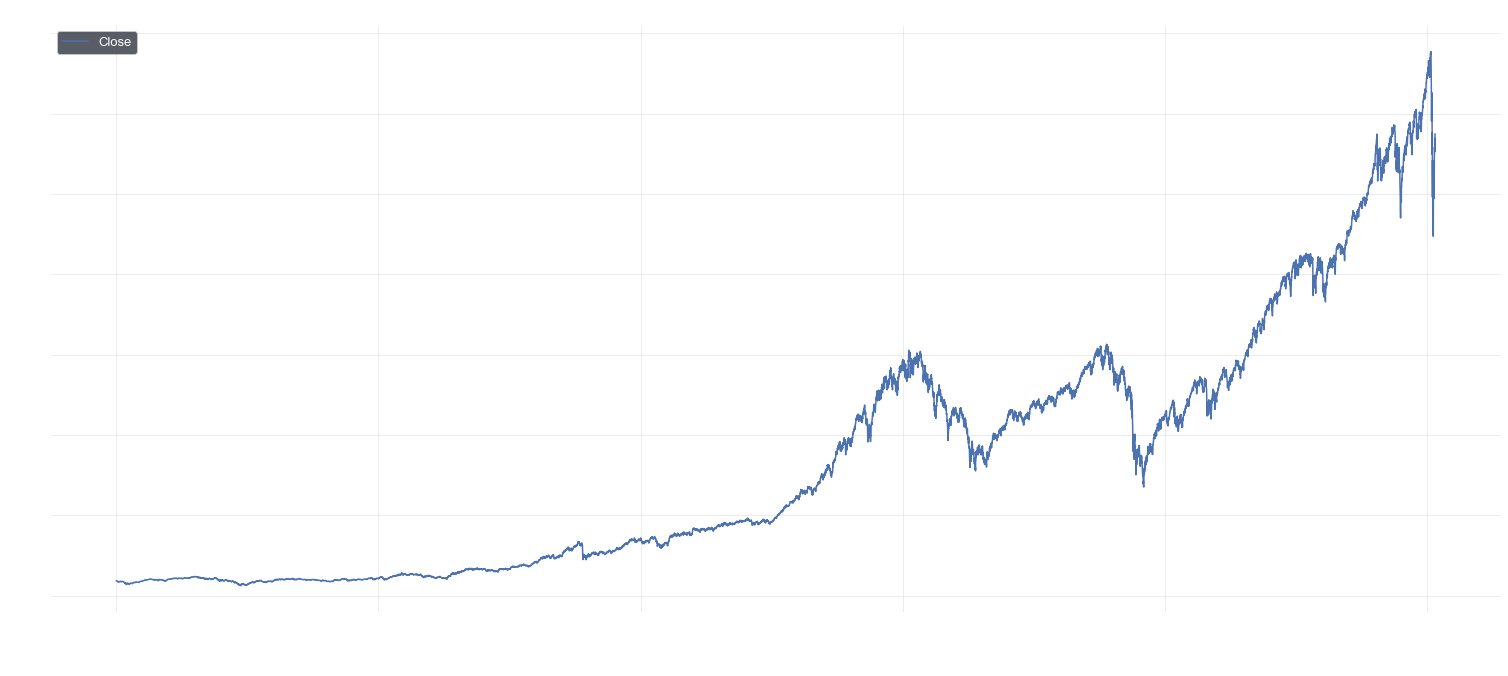

In [9]:
df['Close'].plot(legend=True, title="SP500")

In [10]:
#df.loc['2020', 'Close'].plot(legend=True, title="SP500 in 2020")

## Example of 2 backtests

### 50-200 MA crossover. 2000-now

	Period: 2000-01-03 to 2020-04-17
	Overall return of SP500: 195.65 %. SR of SP500: 0.27
	Overall return of 50-200 MA crossover: 211.24 %. Sharpe ratio strategy: 0.29


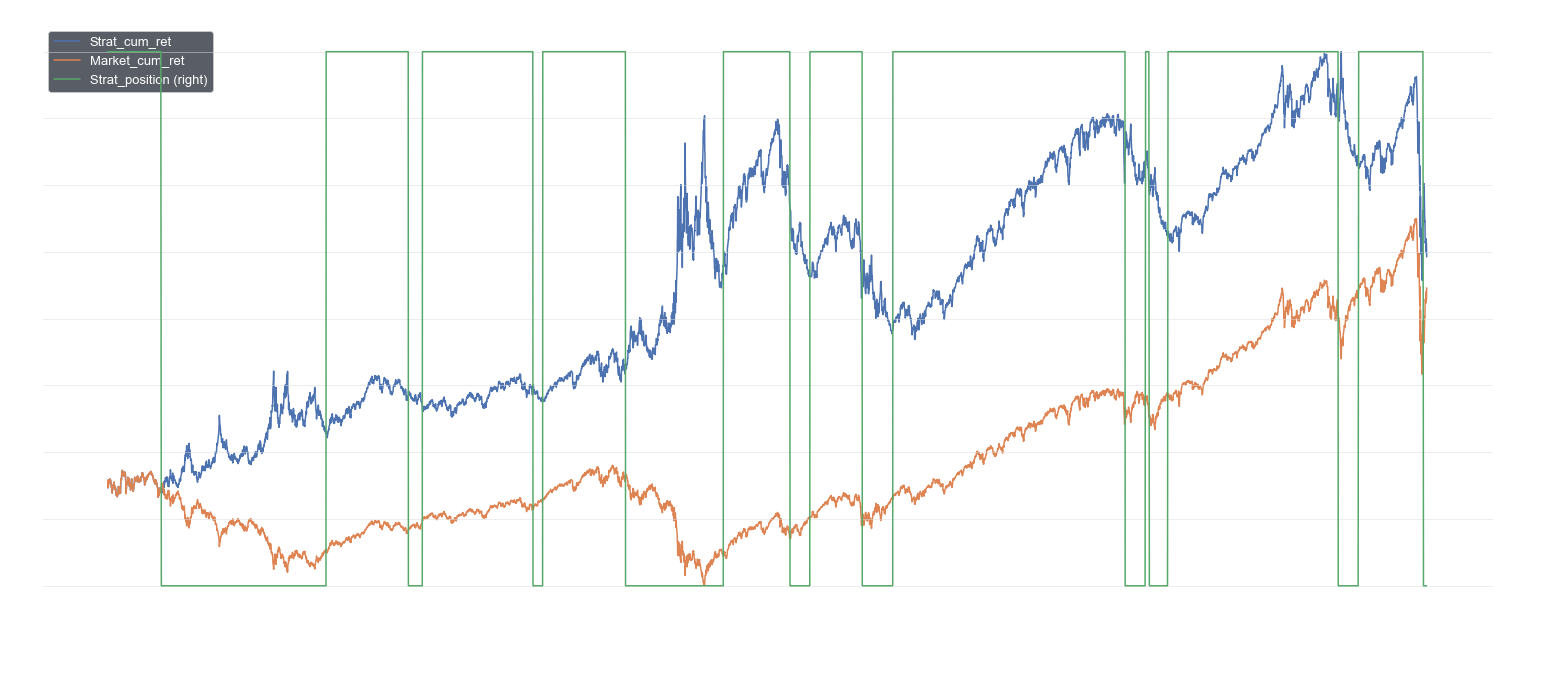

In [11]:
test_df = df.loc['2000':].copy()
_, ret_strat, sr_strat = backtest_ma_strat(test_df, fast_ma=50, slow_ma=200)
print_backtest_stats(test_df, fast_ma=50, slow_ma=200, ret_strat=ret_strat, sr_strat=sr_strat)
show_plot(test_df, start='2000', end='2020')

### 50-200 MA crossover. From 2019-03-28 to 2020-03-31. Good to check transaction costs

	Period: 2019-03-28 to 2020-03-31
	Overall return of SP500: 92.13 %. SR of SP500: -0.13
	Overall return of 50-200 MA crossover: 90.87 %. Sharpe ratio strategy: -0.15


Close  Market_daily_ret  Strat_position  Strat_daily_ret  \
Date                                                                     
2019-03-28  2815.44          0.003590              -1        -0.003590   
2019-03-29  2834.40          0.006734              -1        -0.006734   
2019-04-01  2867.19          0.011569               1        -0.012569   
2019-04-02  2867.24          0.000017               1         0.000017   
2019-04-03  2873.40          0.002148               1         0.002148   
...             ...               ...             ...              ...   
2020-03-25  2475.56          0.011535               1         0.011535   
2020-03-26  2630.07          0.062414               1         0.062414   
2020-03-27  2541.47         -0.033687               1        -0.033687   
2020-03-30  2626.65          0.033516              -1         0.032516   
2020-03-31  2584.59         -0.016013              -1         0.016013   

            Market_cum_ret  Strat_cum_ret  
Date                                       
2019-03-28      100.358954      99.641046  
2019-03-29      101.034801      98.970033  
2019-04-01      102.203631      97.726120  
2019-04-02      102.205413      97.727824  
2019-04-03      102.424992      97.937784  
...                    ...            ...  
2020-03-25       88.243618      84.377692  
2020-03-26       93.751270      89.644055  
2020-03-27       90.593041      86.624187  
2020-03-30       93.629361      89.440862  
2020-03-31       92.130093      90.873060  

[255 rows x 6 columns]

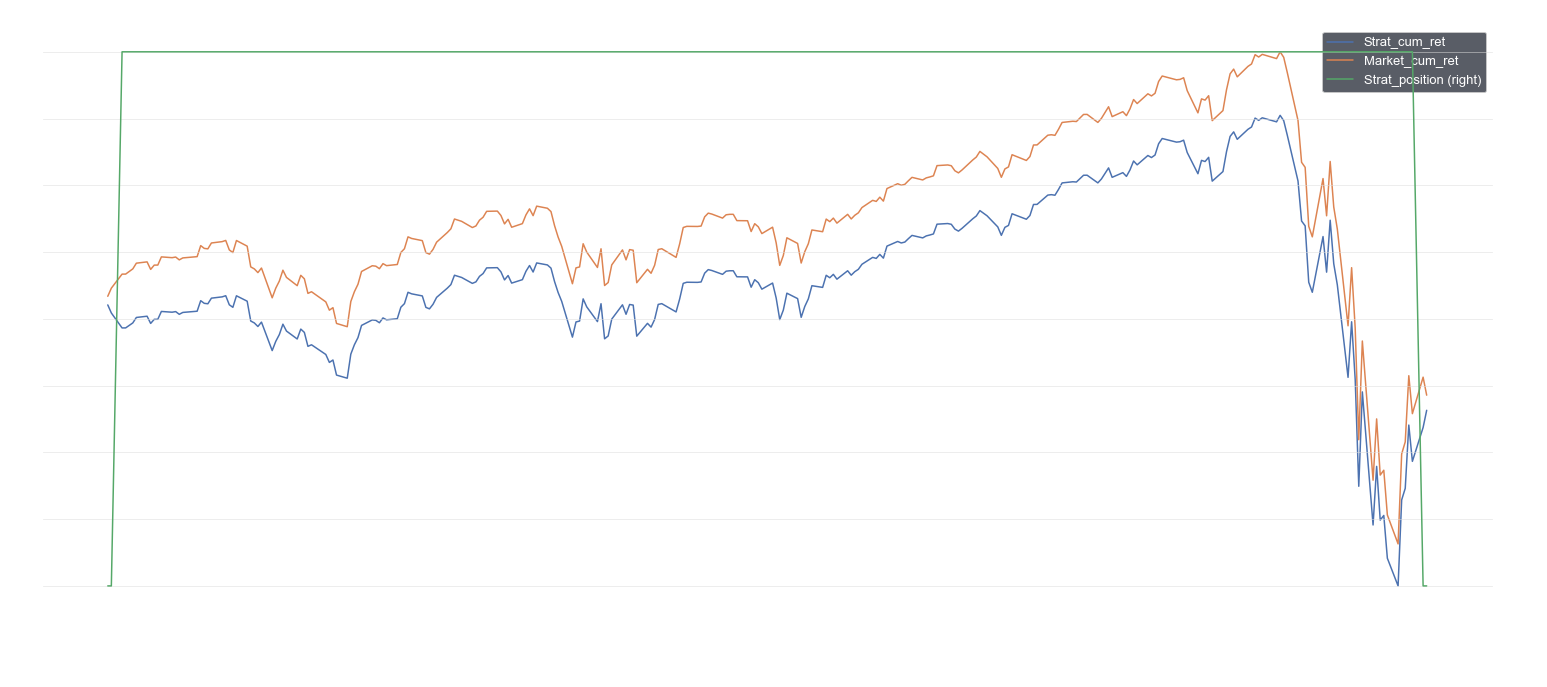

In [12]:
# Good example to see how the changes in the strategy position adds a commision to the daily return
st = '2019-03-28'
end ='2020-03'
test_df = df.loc[st:end].copy()
_, ret_strat, sr_strat = backtest_ma_strat(test_df, fast_ma=50, slow_ma=200)
print_backtest_stats(test_df, fast_ma=50, slow_ma=200, ret_strat=ret_strat, sr_strat=sr_strat)
show_plot(test_df, start=st, end=end)
test_df

## Backtest of multiple combinations of MA crossover accross different periods of time

### Define values of Moving Averages and time periods for optimization

In [13]:
fast_ma = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]
slow_ma = [20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240]

IS_start_years = pd.date_range(start='1970-01-01', end='2017-01-01', freq='1YS', closed=None)
IS_end_years = pd.date_range(start='1972-12-31', end='2019-12-31', freq='1Y', closed=None)
OOS_start_years = pd.date_range(start='1973-01-01', end='2020-01-01', freq='1YS', closed=None)
OOS_end_years = pd.date_range(start='1973-12-31', end='2020-12-31', freq='1Y', closed=None)

#print_periods(IS_start_years, IS_end_years, OOS_start_years, OOS_end_years)

### Walk Forward Optimization

In [14]:
%run Helper.ipynb
from Helper import *

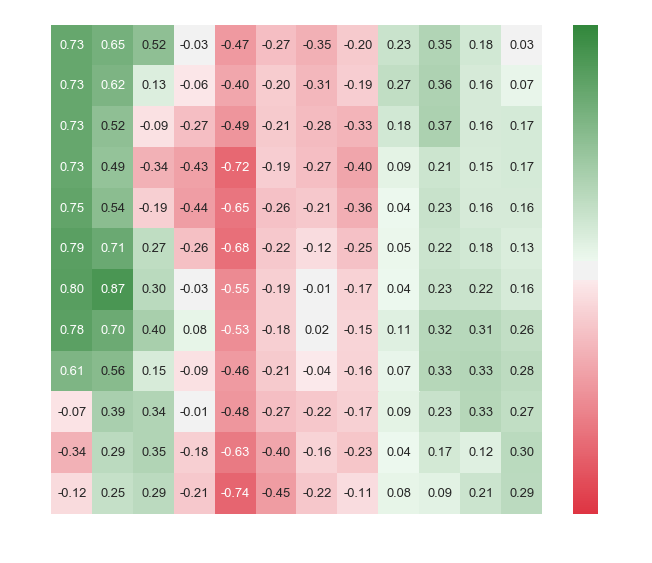

Best In-sample performance:
	Period: 1970-01-02 to 1972-12-29
	Overall return of SP500: 126.94 %. SR of SP500: 0.73
	Overall return of 30-40 MA crossover: 146.39 %. Sharpe ratio strategy: 0.87
OOS performance:
	Period: 1973-01-02 to 1973-12-31
	Overall return of SP500: 82.63 %. SR of SP500: -1.18
	Overall return of 30-40 MA crossover: 99.11 %. Sharpe ratio strategy: -0.03



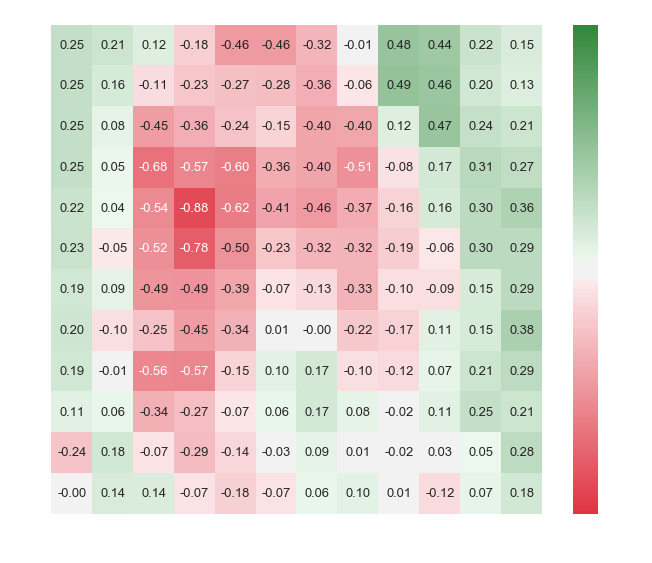

Best In-sample performance:
	Period: 1971-01-04 to 1973-12-31
	Overall return of SP500: 105.86 %. SR of SP500: 0.25
	Overall return of 55-180 MA crossover: 128.02 %. Sharpe ratio strategy: 0.49
OOS performance:
	Period: 1974-01-02 to 1974-12-31
	Overall return of SP500: 70.28 %. SR of SP500: -1.51
	Overall return of 55-180 MA crossover: 135.61 %. Sharpe ratio strategy: 1.51



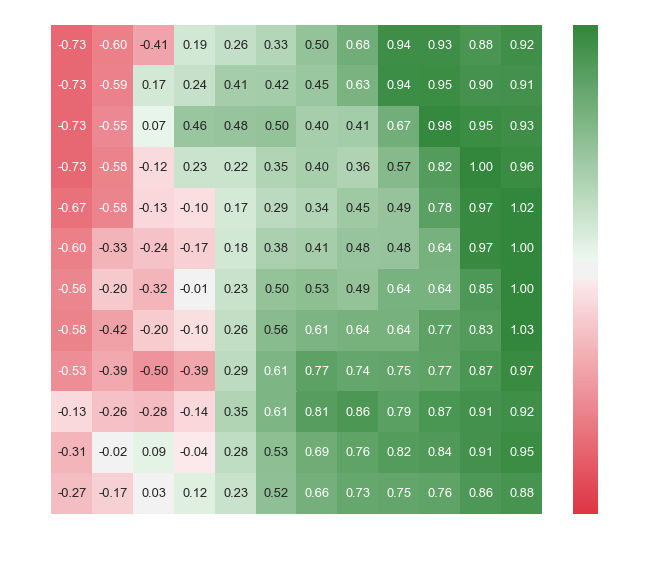

Best In-sample performance:
	Period: 1972-01-03 to 1974-12-31
	Overall return of SP500: 67.16 %. SR of SP500: -0.73
	Overall return of 25-240 MA crossover: 169.12 %. Sharpe ratio strategy: 1.03
OOS performance:
	Period: 1975-01-02 to 1975-12-31
	Overall return of SP500: 131.55 %. SR of SP500: 1.71
	Overall return of 25-240 MA crossover: 92.22 %. Sharpe ratio strategy: -0.29



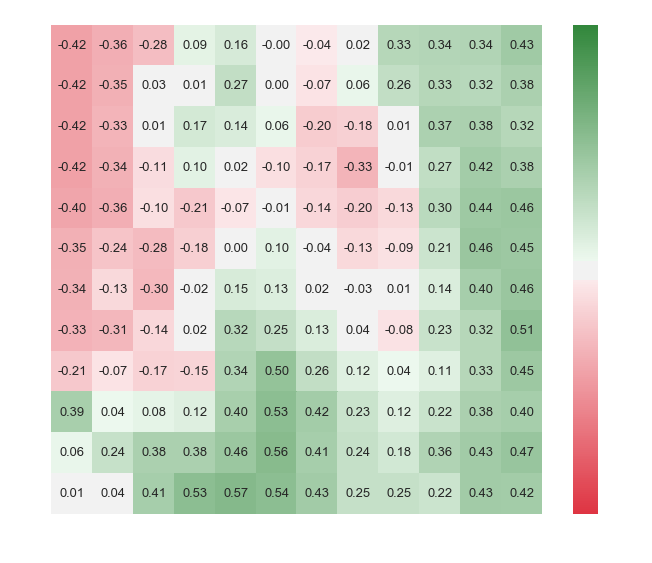

Best In-sample performance:
	Period: 1973-01-02 to 1975-12-31
	Overall return of SP500: 76.40 %. SR of SP500: -0.42
	Overall return of 5-100 MA crossover: 136.03 %. Sharpe ratio strategy: 0.57
OOS performance:
	Period: 1976-01-02 to 1976-12-31
	Overall return of SP500: 119.15 %. SR of SP500: 1.56
	Overall return of 5-100 MA crossover: 104.80 %. Sharpe ratio strategy: 0.40



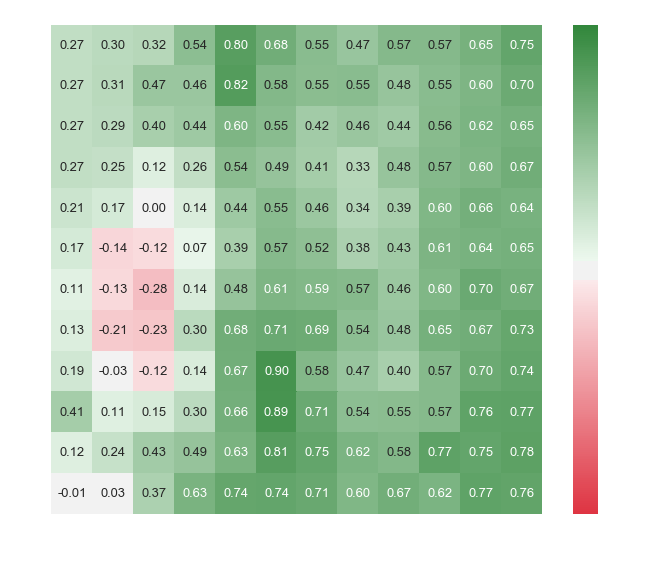

Best In-sample performance:
	Period: 1974-01-02 to 1976-12-31
	Overall return of SP500: 110.16 %. SR of SP500: 0.27
	Overall return of 20-120 MA crossover: 162.87 %. Sharpe ratio strategy: 0.90
OOS performance:
	Period: 1977-01-03 to 1977-12-30
	Overall return of SP500: 88.50 %. SR of SP500: -1.25
	Overall return of 20-120 MA crossover: 96.71 %. Sharpe ratio strategy: -0.27



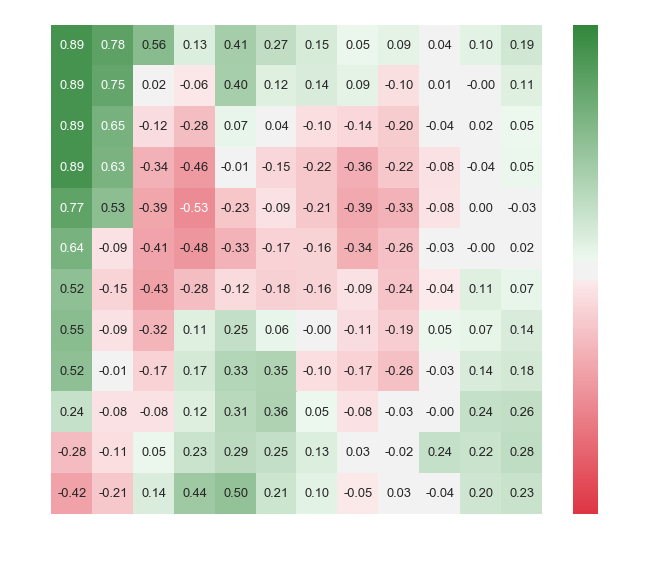

Best In-sample performance:
	Period: 1975-01-02 to 1977-12-30
	Overall return of SP500: 138.71 %. SR of SP500: 0.89
	Overall return of long only: 138.71 %. Sharpe ratio strategy: 0.89
OOS performance:
	Period: 1978-01-03 to 1978-12-29
	Overall return of SP500: 101.06 %. SR of SP500: 0.25
	Overall return of long only: 101.06 %. Sharpe ratio strategy: 0.25



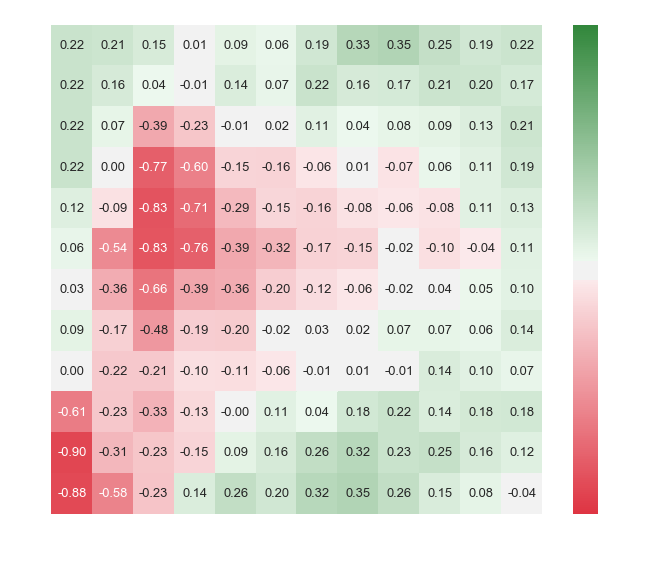

Best In-sample performance:
	Period: 1976-01-02 to 1978-12-29
	Overall return of SP500: 106.56 %. SR of SP500: 0.22
	Overall return of 60-180 MA crossover: 115.90 %. Sharpe ratio strategy: 0.35
OOS performance:
	Period: 1979-01-02 to 1979-12-31
	Overall return of SP500: 112.31 %. SR of SP500: 1.06
	Overall return of 60-180 MA crossover: 97.65 %. Sharpe ratio strategy: -0.10



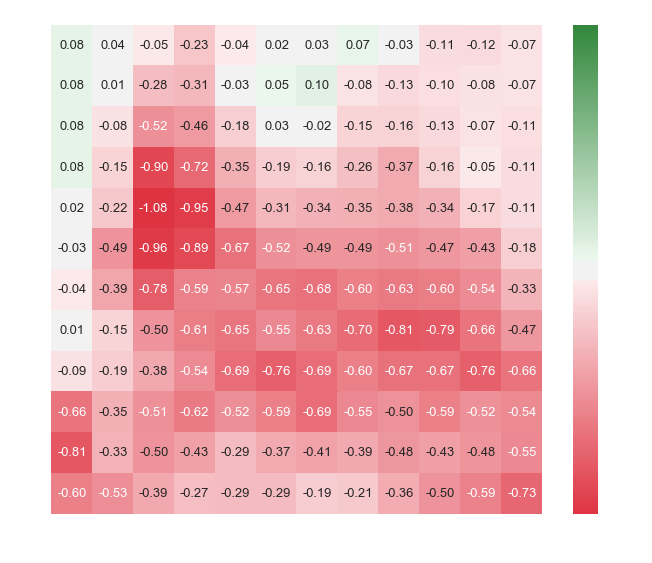

Best In-sample performance:
	Period: 1977-01-03 to 1979-12-31
	Overall return of SP500: 100.45 %. SR of SP500: 0.08
	Overall return of 55-140 MA crossover: 105.46 %. Sharpe ratio strategy: 0.10
OOS performance:
	Period: 1980-01-02 to 1980-12-31
	Overall return of SP500: 125.77 %. SR of SP500: 1.61
	Overall return of 55-140 MA crossover: 100.74 %. Sharpe ratio strategy: 0.00



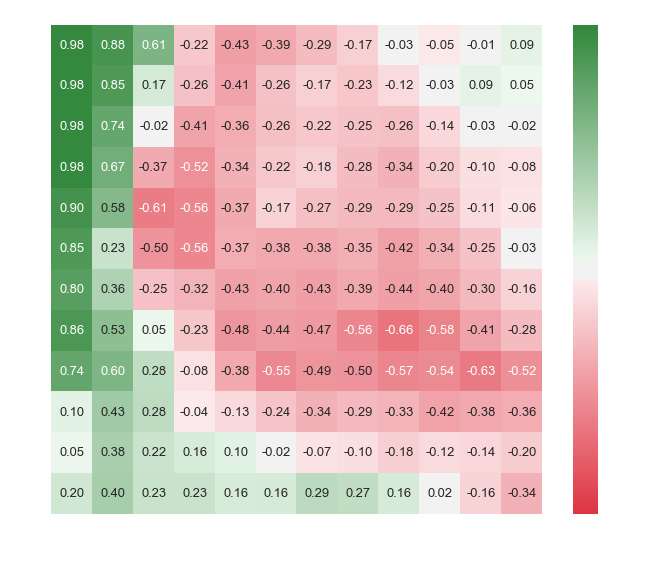

Best In-sample performance:
	Period: 1978-01-03 to 1980-12-31
	Overall return of SP500: 142.75 %. SR of SP500: 0.98
	Overall return of long only: 142.75 %. Sharpe ratio strategy: 0.98
OOS performance:
	Period: 1981-01-02 to 1981-12-31
	Overall return of SP500: 90.27 %. SR of SP500: -0.72
	Overall return of long only: 90.27 %. Sharpe ratio strategy: -0.72



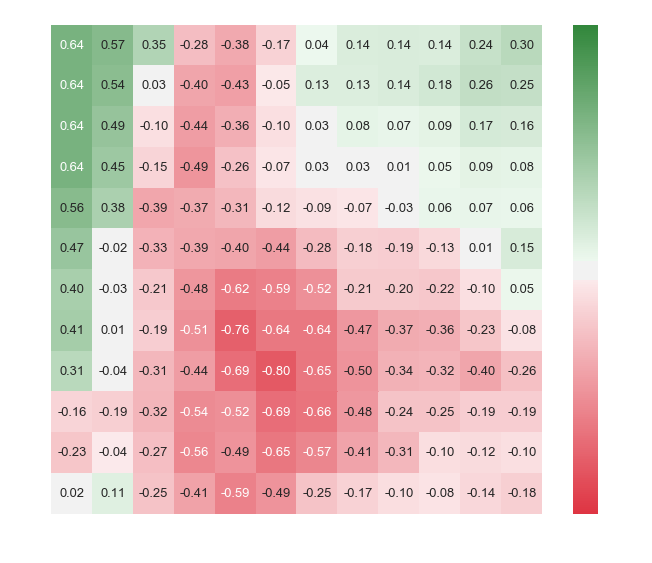

Best In-sample performance:
	Period: 1979-01-02 to 1981-12-31
	Overall return of SP500: 127.51 %. SR of SP500: 0.64
	Overall return of long only: 127.51 %. Sharpe ratio strategy: 0.64
OOS performance:
	Period: 1982-01-04 to 1982-12-31
	Overall return of SP500: 114.76 %. SR of SP500: 0.83
	Overall return of long only: 114.76 %. Sharpe ratio strategy: 0.83



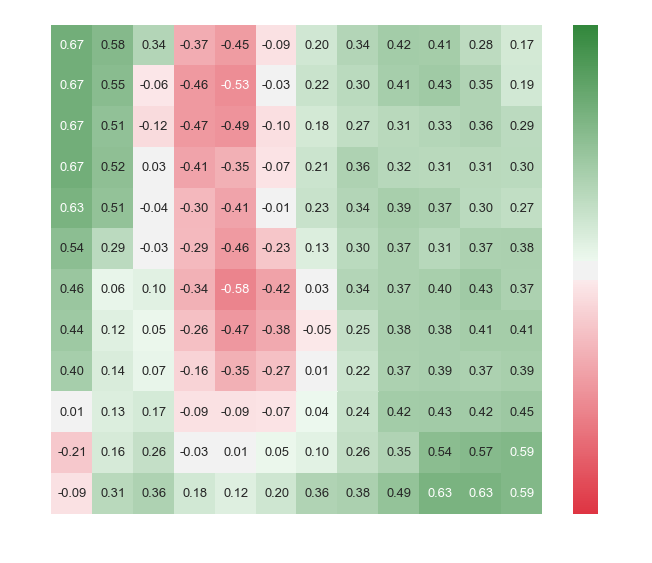

Best In-sample performance:
	Period: 1980-01-02 to 1982-12-31
	Overall return of SP500: 130.29 %. SR of SP500: 0.67
	Overall return of long only: 130.29 %. Sharpe ratio strategy: 0.67
OOS performance:
	Period: 1983-01-03 to 1983-12-30
	Overall return of SP500: 117.27 %. SR of SP500: 1.39
	Overall return of long only: 117.27 %. Sharpe ratio strategy: 1.39



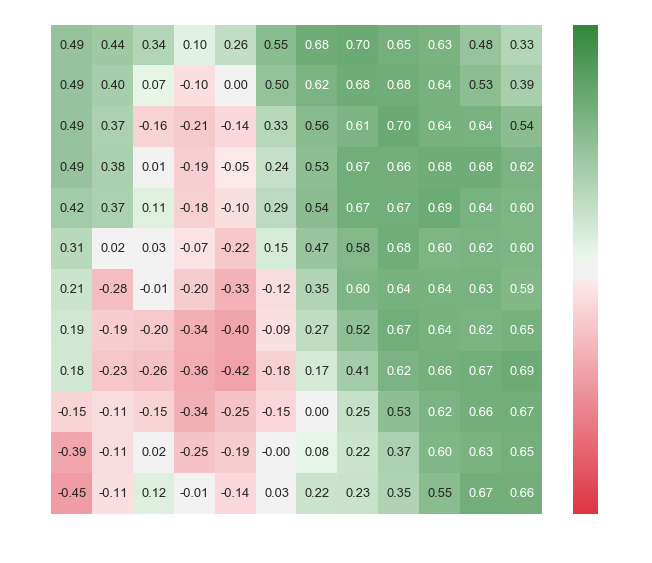

Best In-sample performance:
	Period: 1981-01-02 to 1983-12-30
	Overall return of SP500: 121.49 %. SR of SP500: 0.49
	Overall return of 50-180 MA crossover: 135.78 %. Sharpe ratio strategy: 0.70
OOS performance:
	Period: 1984-01-03 to 1984-12-31
	Overall return of SP500: 101.40 %. SR of SP500: 0.21
	Overall return of 50-180 MA crossover: 96.71 %. Sharpe ratio strategy: -0.24



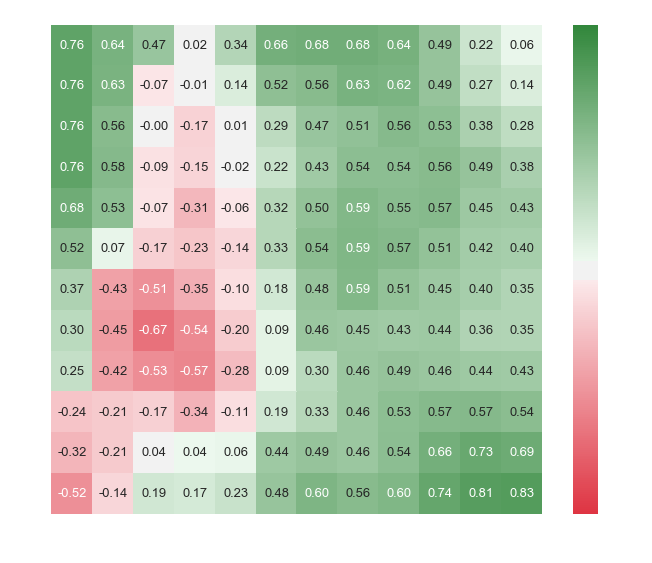

Best In-sample performance:
	Period: 1982-01-04 to 1984-12-31
	Overall return of SP500: 136.47 %. SR of SP500: 0.76
	Overall return of 5-240 MA crossover: 144.41 %. Sharpe ratio strategy: 0.83
OOS performance:
	Period: 1985-01-02 to 1985-12-31
	Overall return of SP500: 126.33 %. SR of SP500: 2.48
	Overall return of 5-240 MA crossover: 126.33 %. Sharpe ratio strategy: 2.48



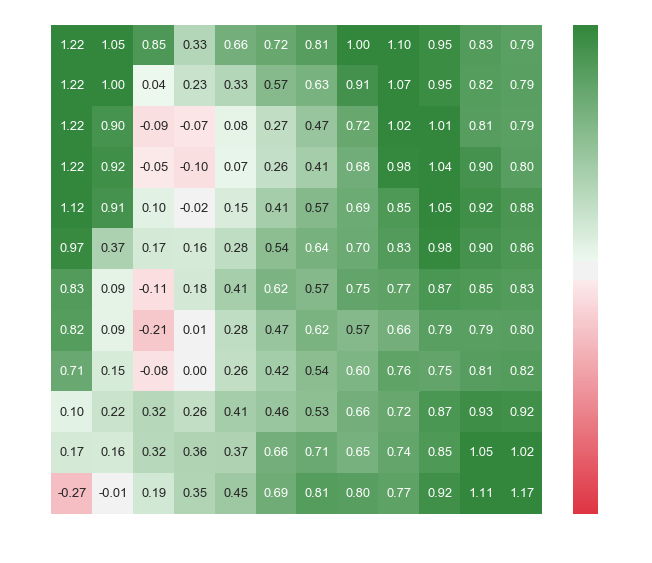

Best In-sample performance:
	Period: 1983-01-03 to 1985-12-31
	Overall return of SP500: 150.23 %. SR of SP500: 1.22
	Overall return of long only: 150.23 %. Sharpe ratio strategy: 1.22
OOS performance:
	Period: 1986-01-02 to 1986-12-31
	Overall return of SP500: 114.62 %. SR of SP500: 1.05
	Overall return of long only: 114.62 %. Sharpe ratio strategy: 1.05



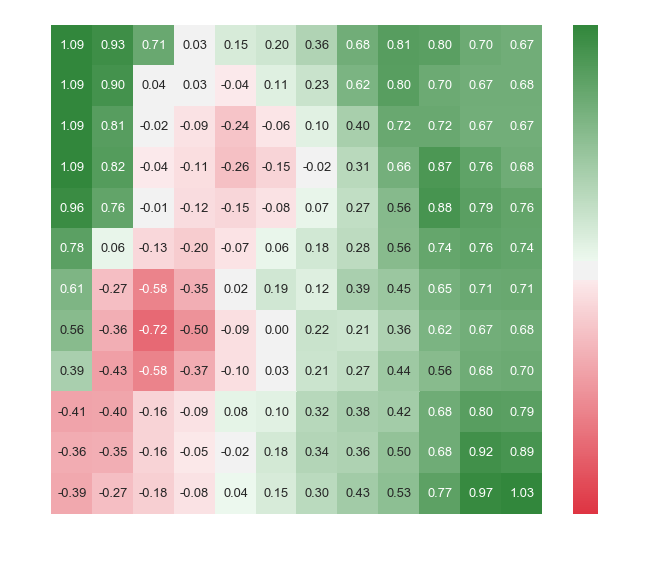

Best In-sample performance:
	Period: 1984-01-03 to 1986-12-31
	Overall return of SP500: 146.83 %. SR of SP500: 1.09
	Overall return of long only: 146.83 %. Sharpe ratio strategy: 1.09
OOS performance:
	Period: 1987-01-02 to 1987-12-31
	Overall return of SP500: 102.03 %. SR of SP500: 0.18
	Overall return of long only: 102.03 %. Sharpe ratio strategy: 0.18



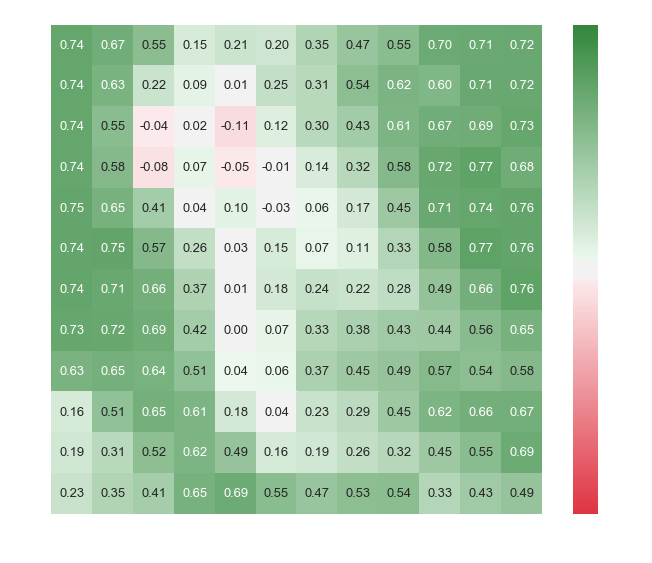

Best In-sample performance:
	Period: 1985-01-02 to 1987-12-31
	Overall return of SP500: 147.74 %. SR of SP500: 0.74
	Overall return of 35-220 MA crossover: 156.03 %. Sharpe ratio strategy: 0.77
OOS performance:
	Period: 1988-01-04 to 1988-12-30
	Overall return of SP500: 112.40 %. SR of SP500: 0.57
	Overall return of 35-220 MA crossover: 92.00 %. Sharpe ratio strategy: -0.20



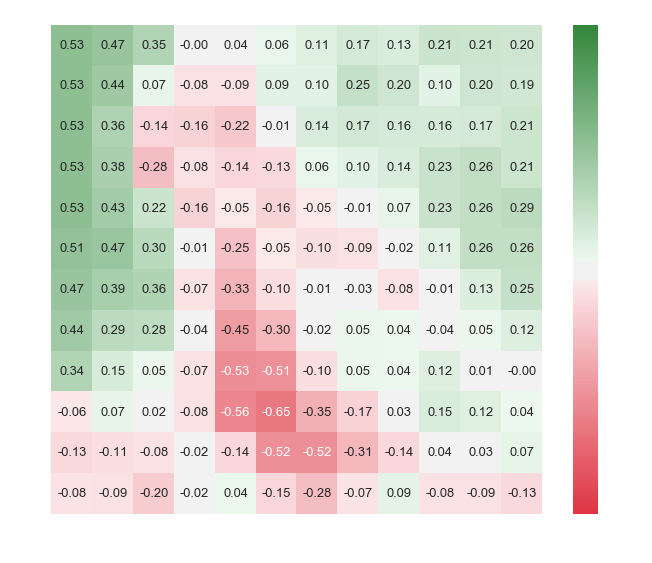

Best In-sample performance:
	Period: 1986-01-02 to 1988-12-30
	Overall return of SP500: 131.45 %. SR of SP500: 0.53
	Overall return of long only: 131.45 %. Sharpe ratio strategy: 0.53
OOS performance:
	Period: 1989-01-03 to 1989-12-29
	Overall return of SP500: 127.25 %. SR of SP500: 1.98
	Overall return of long only: 127.25 %. Sharpe ratio strategy: 1.98



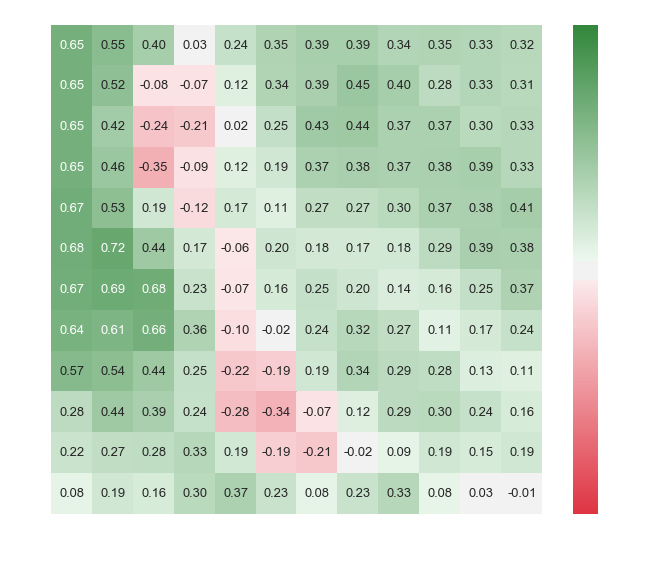

Best In-sample performance:
	Period: 1987-01-02 to 1989-12-29
	Overall return of SP500: 145.93 %. SR of SP500: 0.65
	Overall return of 35-40 MA crossover: 165.99 %. Sharpe ratio strategy: 0.72
OOS performance:
	Period: 1990-01-02 to 1990-12-31
	Overall return of SP500: 93.44 %. SR of SP500: -0.46
	Overall return of 35-40 MA crossover: 97.47 %. Sharpe ratio strategy: -0.19



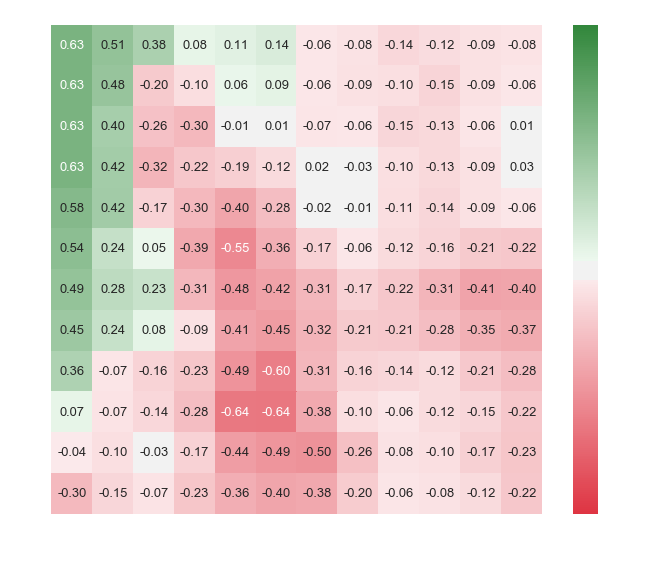

Best In-sample performance:
	Period: 1988-01-04 to 1990-12-31
	Overall return of SP500: 133.65 %. SR of SP500: 0.63
	Overall return of long only: 133.65 %. Sharpe ratio strategy: 0.63
OOS performance:
	Period: 1991-01-02 to 1991-12-31
	Overall return of SP500: 126.31 %. SR of SP500: 1.78
	Overall return of long only: 126.31 %. Sharpe ratio strategy: 1.78



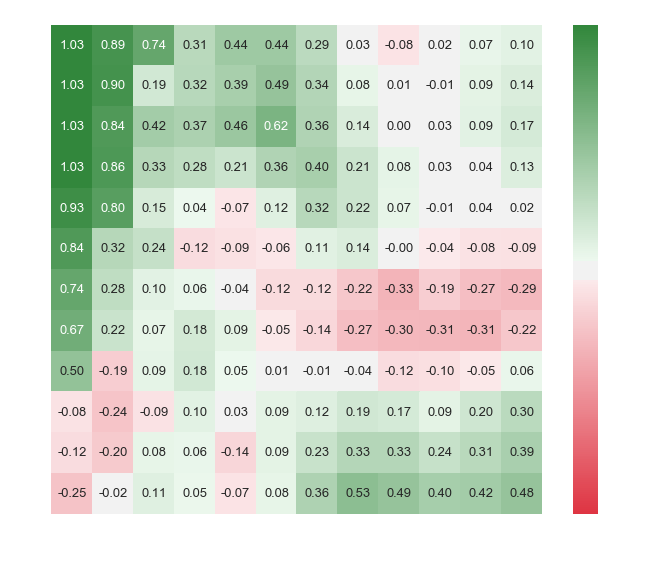

Best In-sample performance:
	Period: 1989-01-03 to 1991-12-31
	Overall return of SP500: 150.18 %. SR of SP500: 1.03
	Overall return of long only: 150.18 %. Sharpe ratio strategy: 1.03
OOS performance:
	Period: 1992-01-02 to 1992-12-31
	Overall return of SP500: 104.46 %. SR of SP500: 0.49
	Overall return of long only: 104.46 %. Sharpe ratio strategy: 0.49



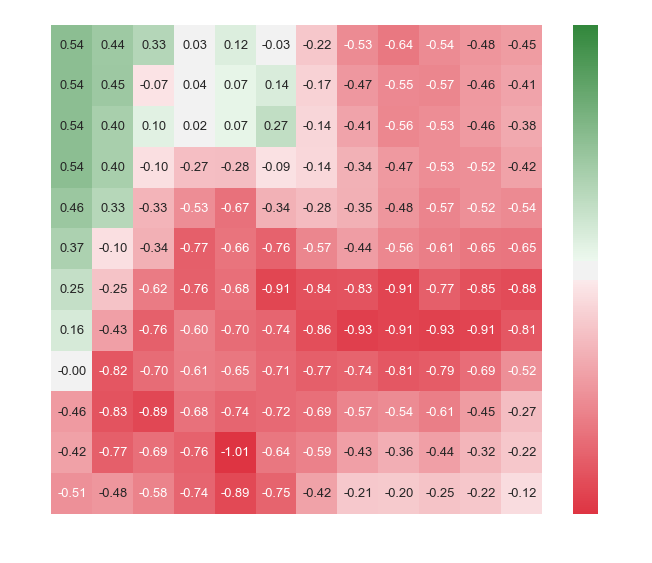

Best In-sample performance:
	Period: 1990-01-02 to 1992-12-31
	Overall return of SP500: 123.29 %. SR of SP500: 0.54
	Overall return of long only: 123.29 %. Sharpe ratio strategy: 0.54
OOS performance:
	Period: 1993-01-04 to 1993-12-31
	Overall return of SP500: 107.06 %. SR of SP500: 0.84
	Overall return of long only: 107.06 %. Sharpe ratio strategy: 0.84



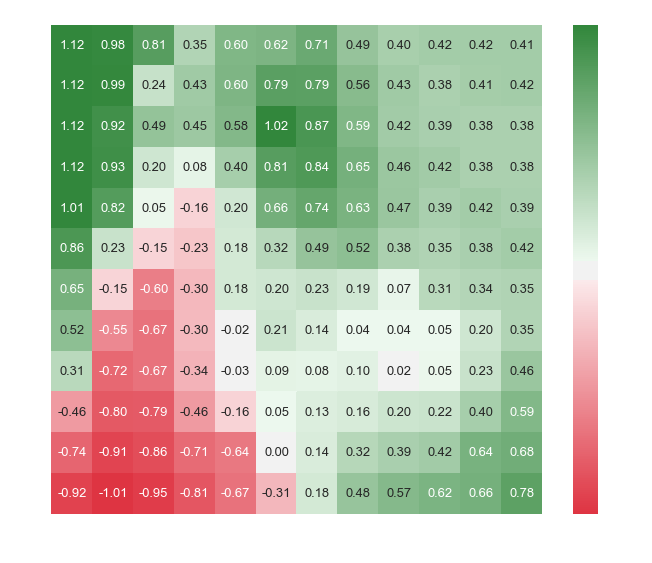

Best In-sample performance:
	Period: 1991-01-02 to 1993-12-31
	Overall return of SP500: 141.25 %. SR of SP500: 1.12
	Overall return of long only: 141.25 %. Sharpe ratio strategy: 1.12
OOS performance:
	Period: 1994-01-03 to 1994-12-30
	Overall return of SP500: 98.46 %. SR of SP500: -0.09
	Overall return of long only: 98.46 %. Sharpe ratio strategy: -0.09



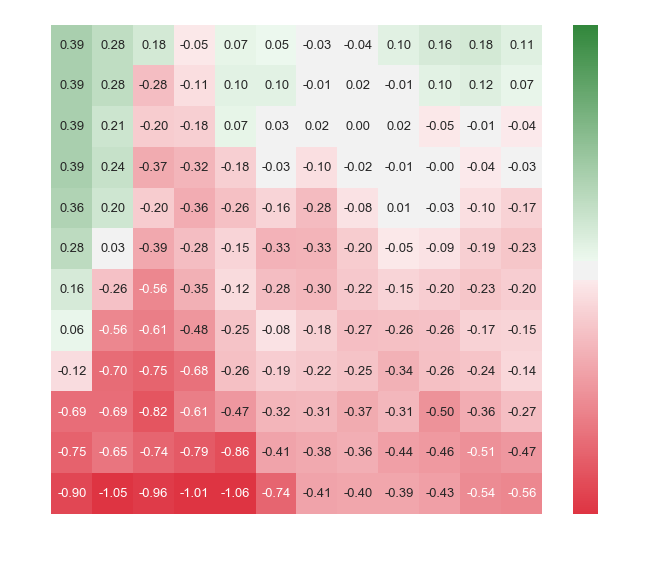

Best In-sample performance:
	Period: 1992-01-02 to 1994-12-30
	Overall return of SP500: 110.11 %. SR of SP500: 0.39
	Overall return of long only: 110.11 %. Sharpe ratio strategy: 0.39
OOS performance:
	Period: 1995-01-03 to 1995-12-29
	Overall return of SP500: 134.11 %. SR of SP500: 3.81
	Overall return of long only: 134.11 %. Sharpe ratio strategy: 3.81



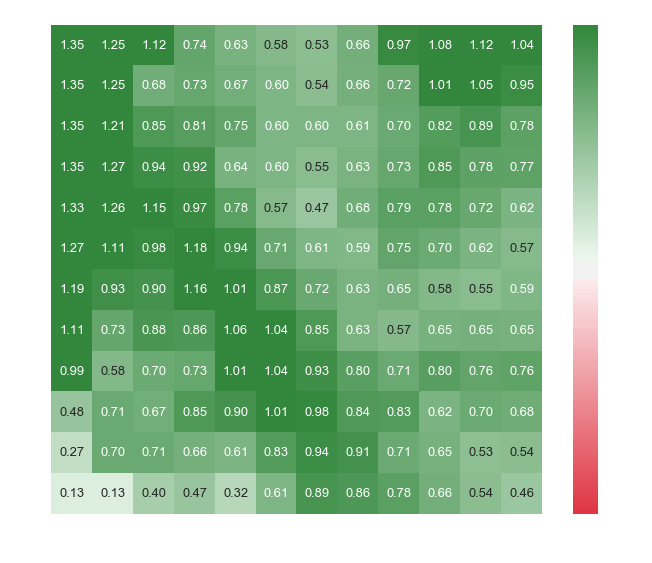

Best In-sample performance:
	Period: 1993-01-04 to 1995-12-29
	Overall return of SP500: 141.36 %. SR of SP500: 1.35
	Overall return of long only: 141.36 %. Sharpe ratio strategy: 1.35
OOS performance:
	Period: 1996-01-02 to 1996-12-31
	Overall return of SP500: 120.26 %. SR of SP500: 1.55
	Overall return of long only: 120.26 %. Sharpe ratio strategy: 1.55



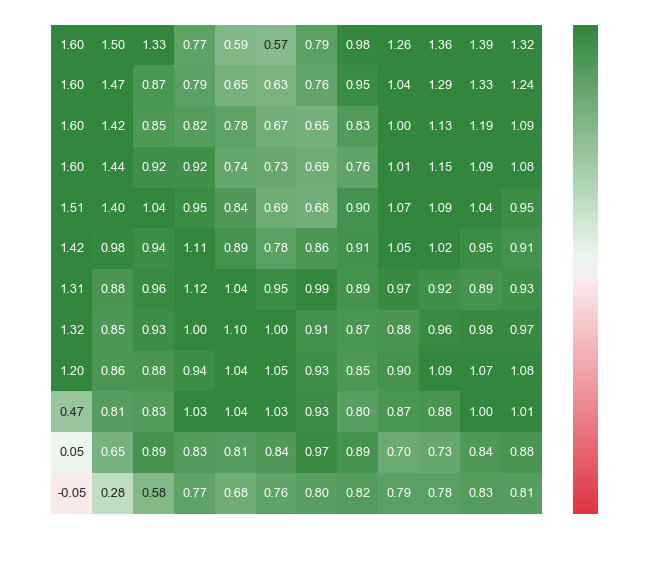

Best In-sample performance:
	Period: 1994-01-03 to 1996-12-31
	Overall return of SP500: 158.80 %. SR of SP500: 1.60
	Overall return of long only: 158.80 %. Sharpe ratio strategy: 1.60
OOS performance:
	Period: 1997-01-02 to 1997-12-31
	Overall return of SP500: 131.01 %. SR of SP500: 1.60
	Overall return of long only: 131.01 %. Sharpe ratio strategy: 1.60



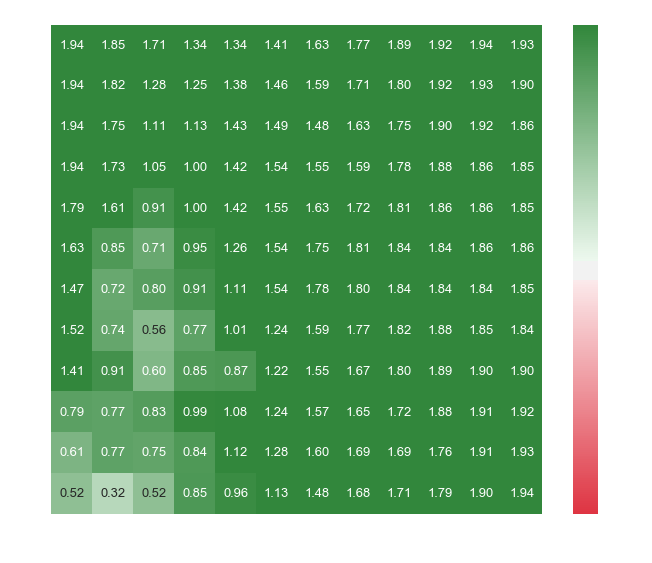

Best In-sample performance:
	Period: 1995-01-03 to 1997-12-31
	Overall return of SP500: 211.30 %. SR of SP500: 1.94
	Overall return of long only: 211.30 %. Sharpe ratio strategy: 1.94
OOS performance:
	Period: 1998-01-02 to 1998-12-31
	Overall return of SP500: 126.67 %. SR of SP500: 1.24
	Overall return of long only: 126.67 %. Sharpe ratio strategy: 1.24



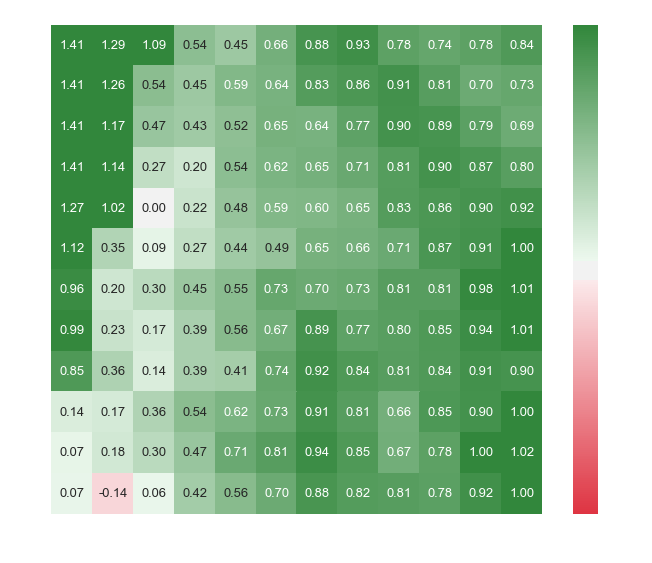

Best In-sample performance:
	Period: 1996-01-02 to 1998-12-31
	Overall return of SP500: 199.57 %. SR of SP500: 1.41
	Overall return of long only: 199.57 %. Sharpe ratio strategy: 1.41
OOS performance:
	Period: 1999-01-04 to 1999-12-31
	Overall return of SP500: 119.53 %. SR of SP500: 1.08
	Overall return of long only: 119.53 %. Sharpe ratio strategy: 1.08



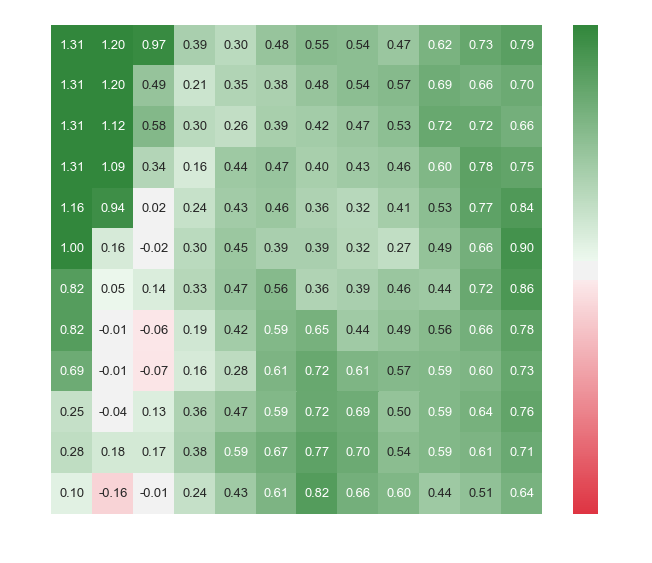

Best In-sample performance:
	Period: 1997-01-02 to 1999-12-31
	Overall return of SP500: 198.35 %. SR of SP500: 1.31
	Overall return of long only: 198.35 %. Sharpe ratio strategy: 1.31
OOS performance:
	Period: 2000-01-03 to 2000-12-29
	Overall return of SP500: 89.86 %. SR of SP500: -0.33
	Overall return of long only: 89.86 %. Sharpe ratio strategy: -0.33



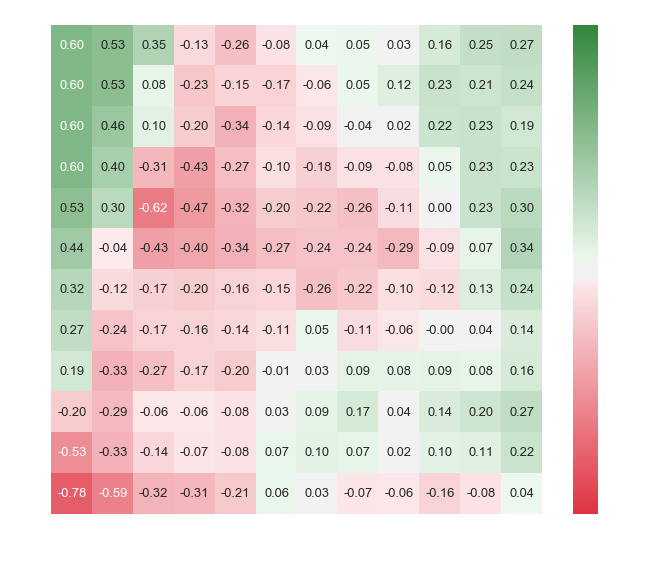

Best In-sample performance:
	Period: 1998-01-02 to 2000-12-29
	Overall return of SP500: 136.05 %. SR of SP500: 0.60
	Overall return of long only: 136.05 %. Sharpe ratio strategy: 0.60
OOS performance:
	Period: 2001-01-02 to 2001-12-31
	Overall return of SP500: 86.96 %. SR of SP500: -0.42
	Overall return of long only: 86.96 %. Sharpe ratio strategy: -0.42



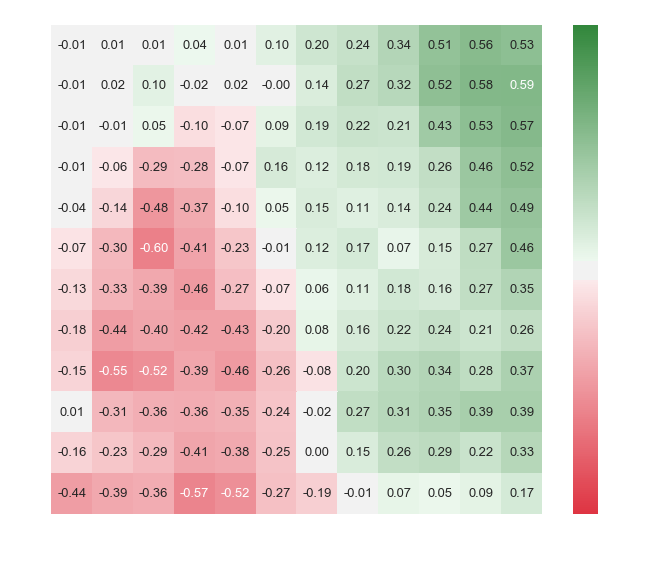

Best In-sample performance:
	Period: 1999-01-04 to 2001-12-31
	Overall return of SP500: 93.40 %. SR of SP500: -0.01
	Overall return of 55-240 MA crossover: 137.49 %. Sharpe ratio strategy: 0.59
OOS performance:
	Period: 2002-01-02 to 2002-12-31
	Overall return of SP500: 76.63 %. SR of SP500: -0.92
	Overall return of 55-240 MA crossover: 121.94 %. Sharpe ratio strategy: 0.92



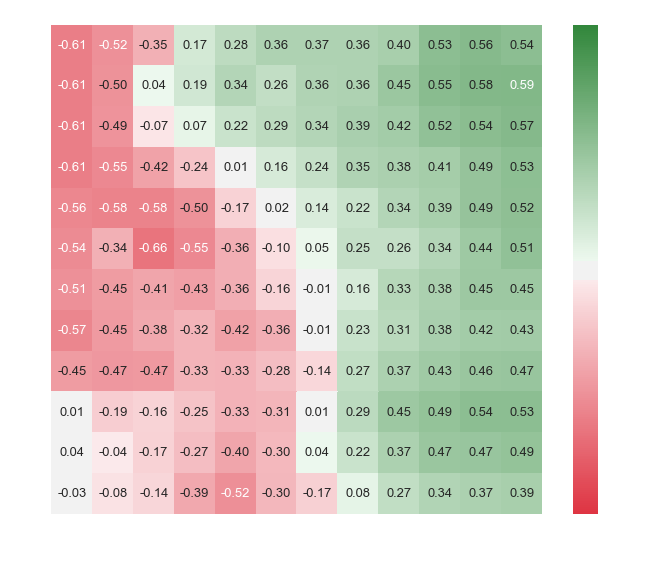

Best In-sample performance:
	Period: 2000-01-03 to 2002-12-31
	Overall return of SP500: 59.88 %. SR of SP500: -0.61
	Overall return of 55-240 MA crossover: 140.27 %. Sharpe ratio strategy: 0.59
OOS performance:
	Period: 2003-01-02 to 2003-12-31
	Overall return of SP500: 126.38 %. SR of SP500: 1.29
	Overall return of 55-240 MA crossover: 105.93 %. Sharpe ratio strategy: 0.63



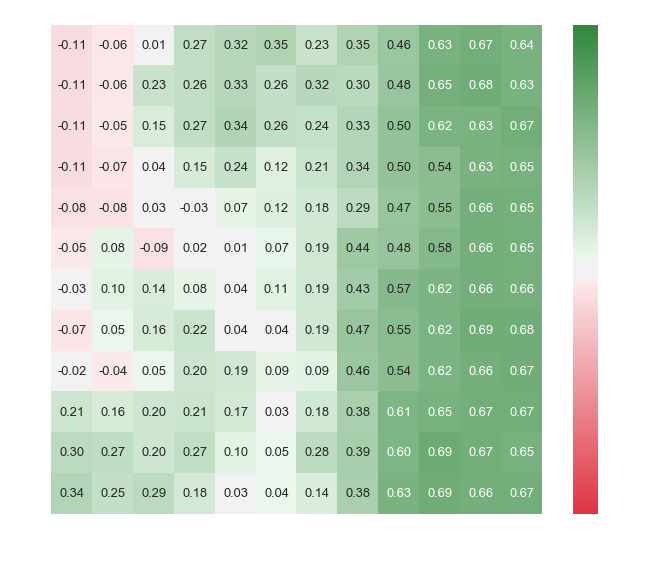

Best In-sample performance:
	Period: 2001-01-02 to 2003-12-31
	Overall return of SP500: 84.22 %. SR of SP500: -0.11
	Overall return of 10-200 MA crossover: 153.13 %. Sharpe ratio strategy: 0.69
OOS performance:
	Period: 2004-01-02 to 2004-12-31
	Overall return of SP500: 108.99 %. SR of SP500: 0.86
	Overall return of 10-200 MA crossover: 88.49 %. Sharpe ratio strategy: -1.02



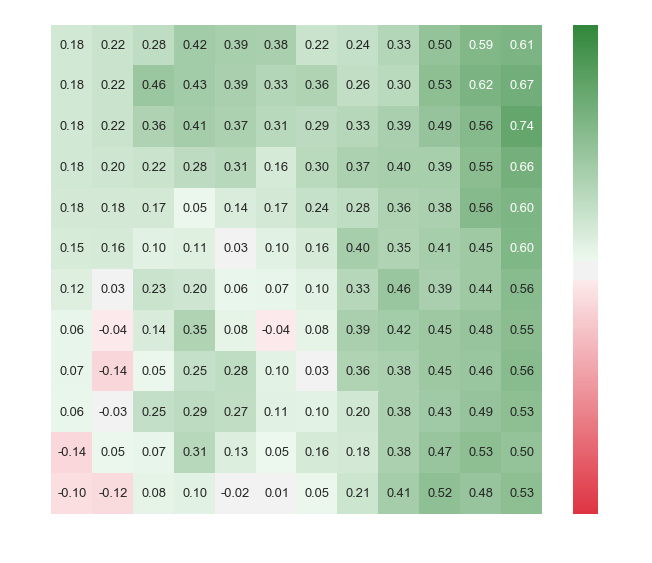

Best In-sample performance:
	Period: 2002-01-02 to 2004-12-31
	Overall return of SP500: 105.56 %. SR of SP500: 0.18
	Overall return of 50-240 MA crossover: 154.95 %. Sharpe ratio strategy: 0.74
OOS performance:
	Period: 2005-01-03 to 2005-12-30
	Overall return of SP500: 103.00 %. SR of SP500: 0.42
	Overall return of 50-240 MA crossover: 103.00 %. Sharpe ratio strategy: 0.42



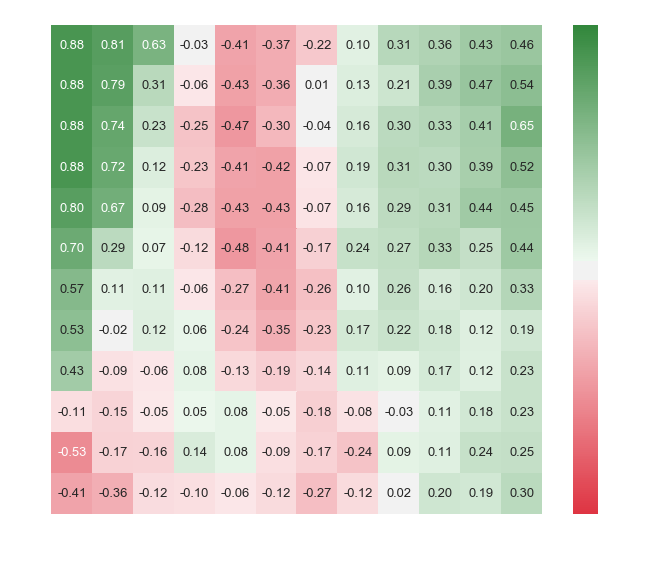

Best In-sample performance:
	Period: 2003-01-02 to 2005-12-30
	Overall return of SP500: 141.88 %. SR of SP500: 0.88
	Overall return of long only: 141.88 %. Sharpe ratio strategy: 0.88
OOS performance:
	Period: 2006-01-03 to 2006-12-29
	Overall return of SP500: 113.62 %. SR of SP500: 1.18
	Overall return of long only: 113.62 %. Sharpe ratio strategy: 1.18



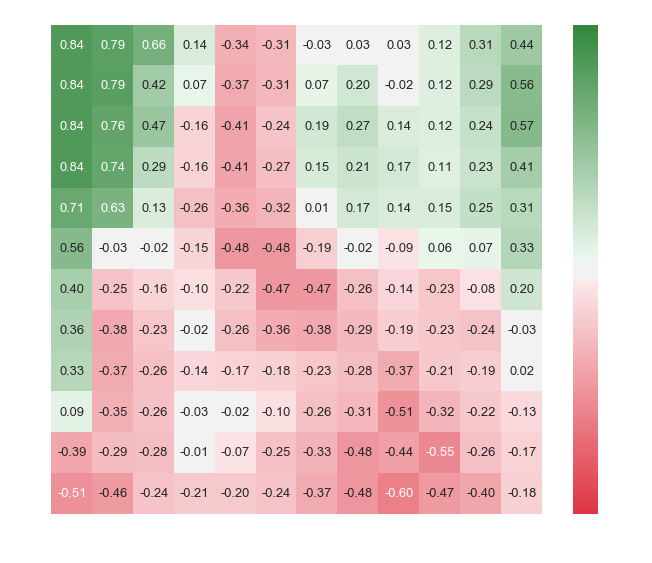

Best In-sample performance:
	Period: 2004-01-02 to 2006-12-29
	Overall return of SP500: 127.55 %. SR of SP500: 0.84
	Overall return of long only: 127.55 %. Sharpe ratio strategy: 0.84
OOS performance:
	Period: 2007-01-03 to 2007-12-31
	Overall return of SP500: 103.53 %. SR of SP500: 0.31
	Overall return of long only: 103.53 %. Sharpe ratio strategy: 0.31



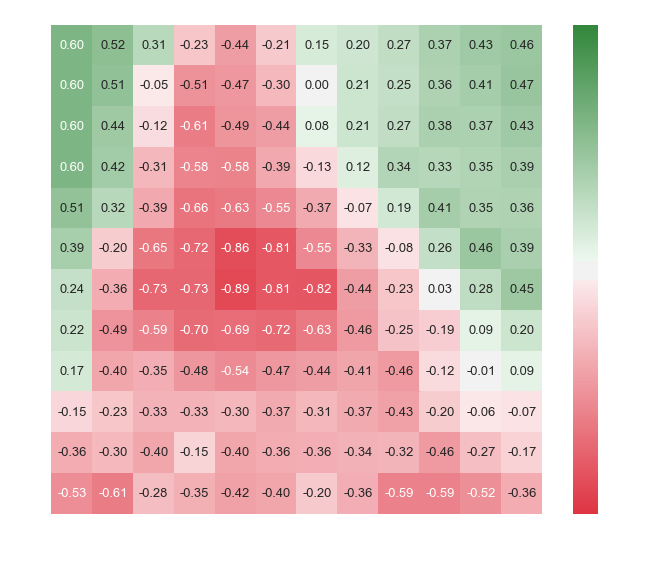

Best In-sample performance:
	Period: 2005-01-03 to 2007-12-31
	Overall return of SP500: 121.16 %. SR of SP500: 0.60
	Overall return of long only: 121.16 %. Sharpe ratio strategy: 0.60
OOS performance:
	Period: 2008-01-02 to 2008-12-31
	Overall return of SP500: 61.51 %. SR of SP500: -0.94
	Overall return of long only: 61.51 %. Sharpe ratio strategy: -0.94



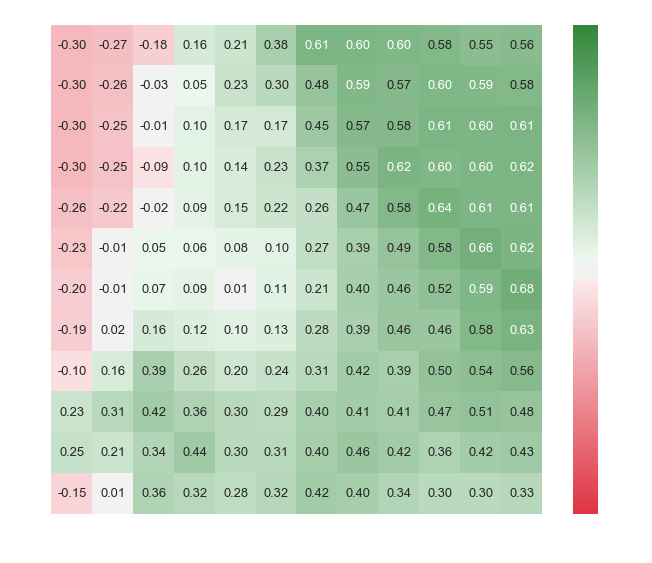

Best In-sample performance:
	Period: 2006-01-03 to 2008-12-31
	Overall return of SP500: 72.36 %. SR of SP500: -0.30
	Overall return of 30-240 MA crossover: 161.50 %. Sharpe ratio strategy: 0.68
OOS performance:
	Period: 2009-01-02 to 2009-12-31
	Overall return of SP500: 123.45 %. SR of SP500: 0.80
	Overall return of 30-240 MA crossover: 96.98 %. Sharpe ratio strategy: 0.14



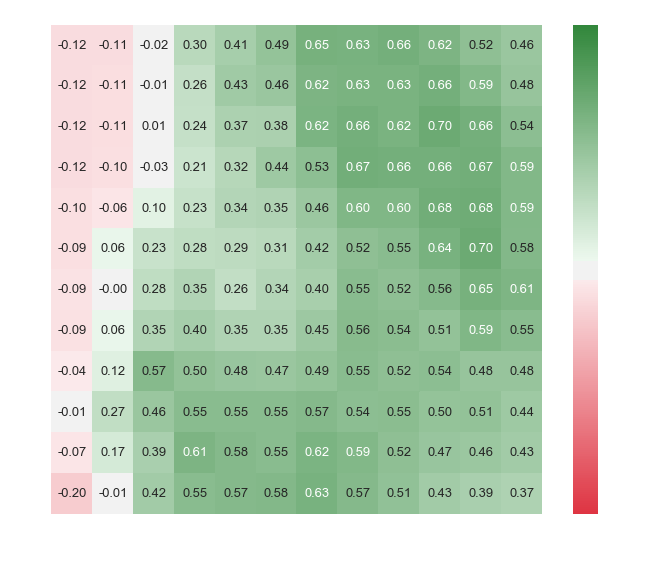

Best In-sample performance:
	Period: 2007-01-03 to 2009-12-31
	Overall return of SP500: 78.62 %. SR of SP500: -0.12
	Overall return of 50-200 MA crossover: 171.76 %. Sharpe ratio strategy: 0.70
OOS performance:
	Period: 2010-01-04 to 2010-12-31
	Overall return of SP500: 112.78 %. SR of SP500: 0.67
	Overall return of 50-200 MA crossover: 83.30 %. Sharpe ratio strategy: -1.02



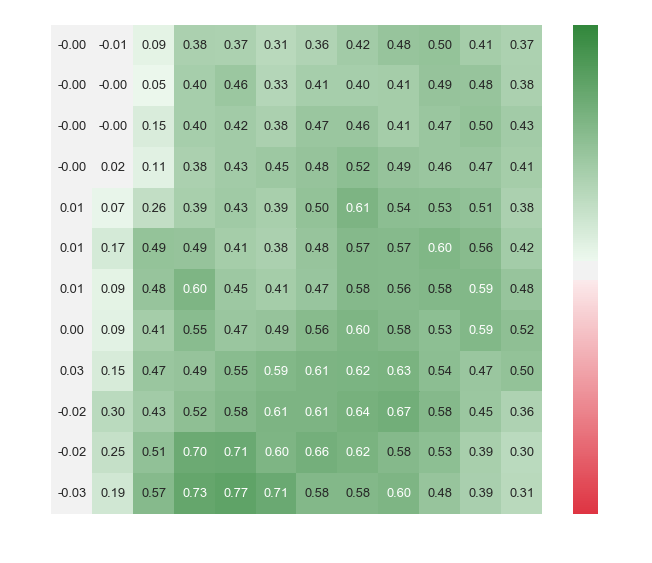

Best In-sample performance:
	Period: 2008-01-02 to 2010-12-31
	Overall return of SP500: 85.65 %. SR of SP500: -0.00
	Overall return of 5-100 MA crossover: 184.75 %. Sharpe ratio strategy: 0.77
OOS performance:
	Period: 2011-01-03 to 2011-12-30
	Overall return of SP500: 100.00 %. SR of SP500: 0.07
	Overall return of 5-100 MA crossover: 85.91 %. Sharpe ratio strategy: -0.59



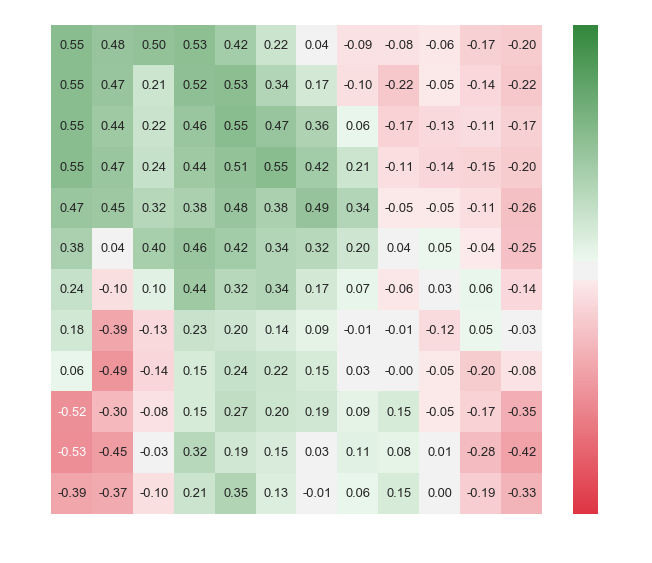

Best In-sample performance:
	Period: 2009-01-02 to 2011-12-30
	Overall return of SP500: 139.23 %. SR of SP500: 0.55
	Overall return of 50-100 MA crossover: 133.00 %. Sharpe ratio strategy: 0.55
OOS performance:
	Period: 2012-01-03 to 2012-12-31
	Overall return of SP500: 113.41 %. SR of SP500: 0.94
	Overall return of 50-100 MA crossover: 96.56 %. Sharpe ratio strategy: -0.34



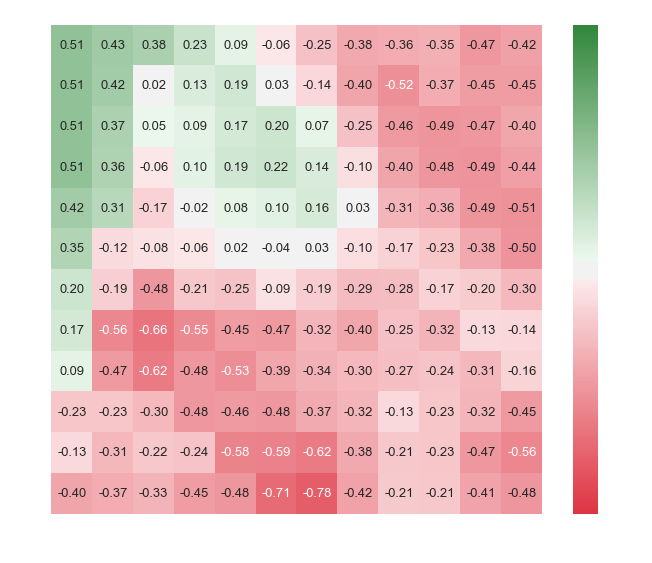

Best In-sample performance:
	Period: 2010-01-04 to 2012-12-31
	Overall return of SP500: 127.90 %. SR of SP500: 0.51
	Overall return of long only: 127.90 %. Sharpe ratio strategy: 0.51
OOS performance:
	Period: 2013-01-02 to 2013-12-31
	Overall return of SP500: 129.60 %. SR of SP500: 2.22
	Overall return of long only: 129.60 %. Sharpe ratio strategy: 2.22



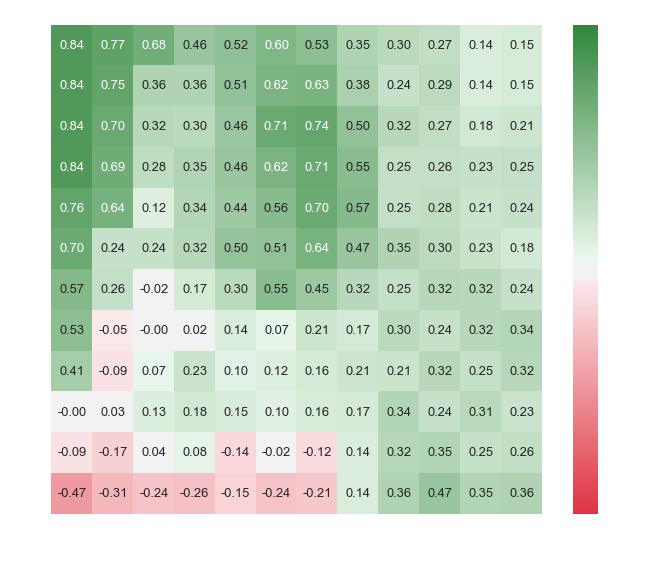

Best In-sample performance:
	Period: 2011-01-03 to 2013-12-31
	Overall return of SP500: 146.97 %. SR of SP500: 0.84
	Overall return of long only: 146.97 %. Sharpe ratio strategy: 0.84
OOS performance:
	Period: 2014-01-02 to 2014-12-31
	Overall return of SP500: 111.39 %. SR of SP500: 1.09
	Overall return of long only: 111.39 %. Sharpe ratio strategy: 1.09



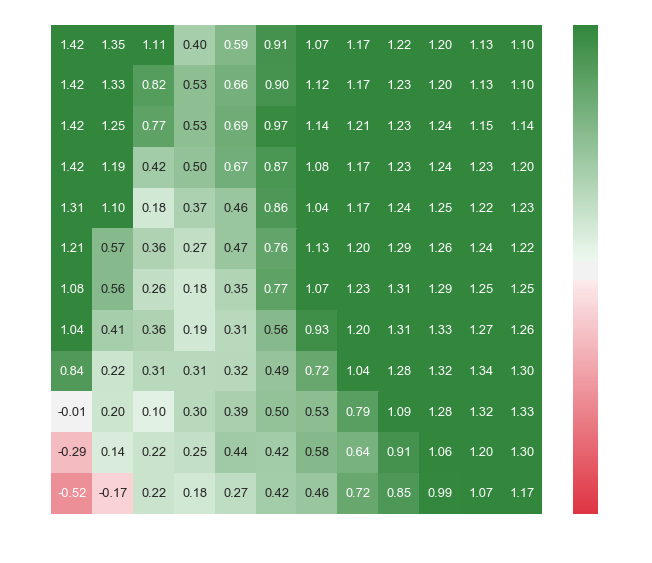

Best In-sample performance:
	Period: 2012-01-03 to 2014-12-31
	Overall return of SP500: 163.72 %. SR of SP500: 1.42
	Overall return of long only: 163.72 %. Sharpe ratio strategy: 1.42
OOS performance:
	Period: 2015-01-02 to 2015-12-31
	Overall return of SP500: 99.27 %. SR of SP500: 0.03
	Overall return of long only: 99.27 %. Sharpe ratio strategy: 0.03



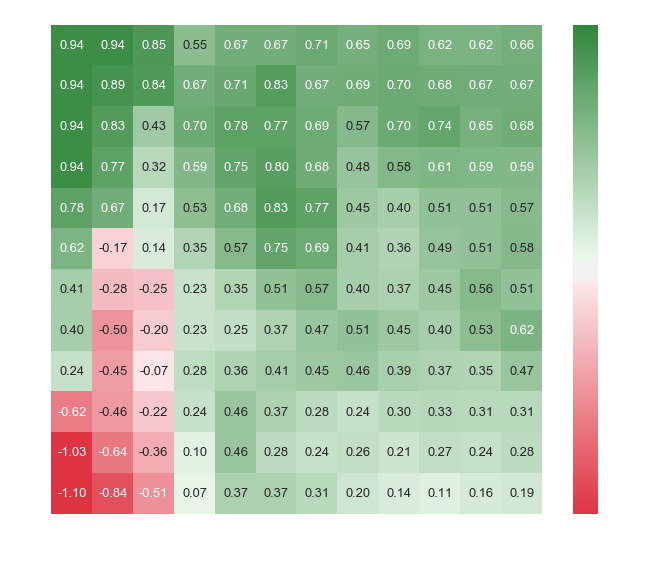

Best In-sample performance:
	Period: 2013-01-02 to 2015-12-31
	Overall return of SP500: 143.31 %. SR of SP500: 0.94
	Overall return of long only: 143.31 %. Sharpe ratio strategy: 0.94
OOS performance:
	Period: 2016-01-04 to 2016-12-30
	Overall return of SP500: 109.54 %. SR of SP500: 0.88
	Overall return of long only: 109.54 %. Sharpe ratio strategy: 0.88



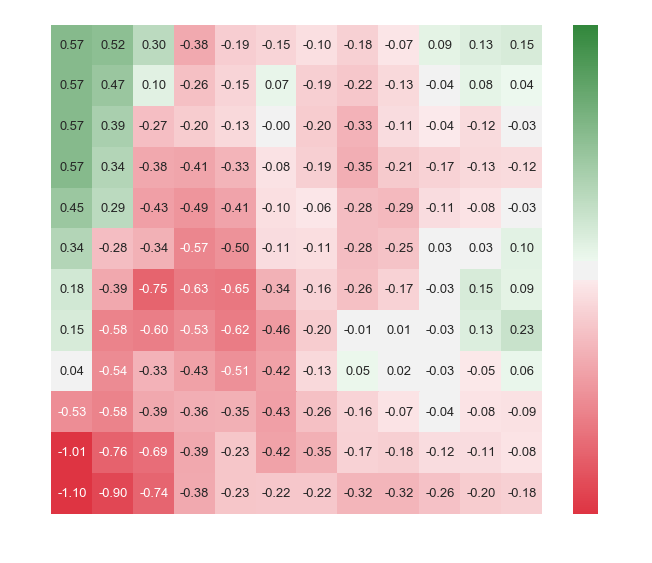

Best In-sample performance:
	Period: 2014-01-02 to 2016-12-30
	Overall return of SP500: 121.13 %. SR of SP500: 0.57
	Overall return of long only: 121.12 %. Sharpe ratio strategy: 0.57
OOS performance:
	Period: 2017-01-03 to 2017-12-29
	Overall return of SP500: 119.42 %. SR of SP500: 2.59
	Overall return of long only: 119.42 %. Sharpe ratio strategy: 2.59



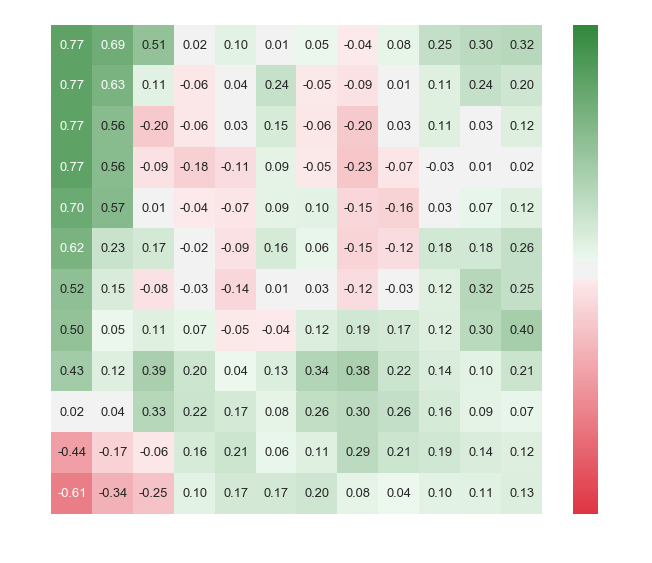

Best In-sample performance:
	Period: 2015-01-02 to 2017-12-29
	Overall return of SP500: 129.86 %. SR of SP500: 0.77
	Overall return of long only: 129.86 %. Sharpe ratio strategy: 0.77
OOS performance:
	Period: 2018-01-02 to 2018-12-31
	Overall return of SP500: 93.76 %. SR of SP500: -0.34
	Overall return of long only: 93.76 %. Sharpe ratio strategy: -0.34



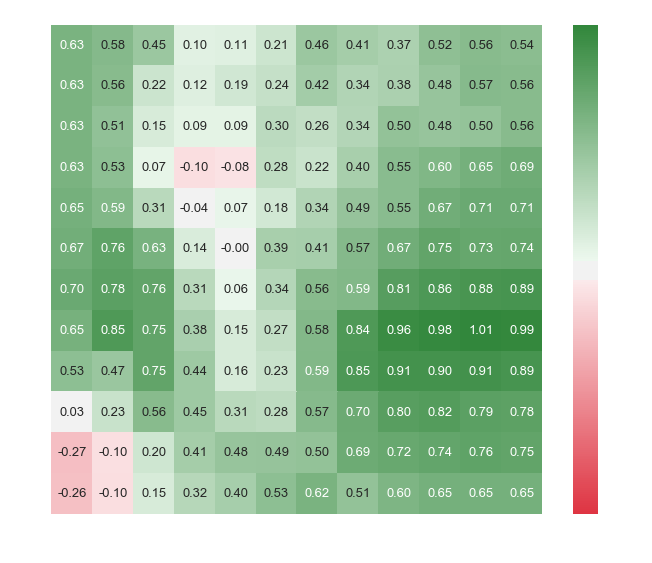

Best In-sample performance:
	Period: 2016-01-04 to 2018-12-31
	Overall return of SP500: 122.65 %. SR of SP500: 0.63
	Overall return of 25-220 MA crossover: 151.40 %. Sharpe ratio strategy: 1.01
OOS performance:
	Period: 2019-01-02 to 2019-12-31
	Overall return of SP500: 128.88 %. SR of SP500: 2.09
	Overall return of 25-220 MA crossover: 103.36 %. Sharpe ratio strategy: 0.34



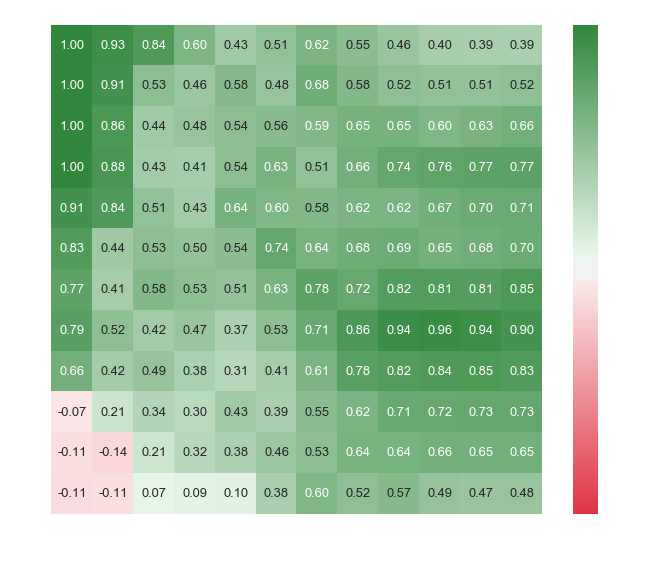

Best In-sample performance:
	Period: 2017-01-03 to 2019-12-31
	Overall return of SP500: 144.31 %. SR of SP500: 1.00
	Overall return of long only: 144.31 %. Sharpe ratio strategy: 1.00
OOS performance:
	Period: 2020-01-02 to 2020-04-17
	Overall return of SP500: 88.97 %. SR of SP500: -0.49
	Overall return of long only: 88.97 %. Sharpe ratio strategy: -0.49

End of optimization


In [15]:
market_pln = []
market_sr = []
oos_pln = []
oos_sr = []

for IS_start, IS_end, OOS_start, OOS_end in zip(IS_start_years, IS_end_years, OOS_start_years, OOS_end_years):
    results_pnl = np.zeros((len(fast_ma),len(slow_ma)))
    results_sharpe = np.zeros((len(fast_ma),len(slow_ma)))

    in_sample = df.loc[IS_start:IS_end].copy()
    oos_sample = df.loc[OOS_start:OOS_end].copy()
    
    ############################################ IN SAMPLE  ############################################
    results_pnl, results_sharpe = run_all_combinations(in_sample, fast_ma, slow_ma)
    # Get index of maximum SR for the In-Sample period
    fast_index, slow_index, results_sharpe = get_best_combination(results_sharpe)

    title = "SR In Sample ("+str(IS_start.date())+":"+ str(IS_end.date()) +")"
    show_heatmap(results_sharpe, plot_title=title, x_title="Slow MA", x_values=slow_ma, y_title="Fast MA", y_values=fast_ma)

    print("Best In-sample performance:")
    print_backtest_stats(in_sample, fast_ma[fast_index], slow_ma[slow_index], results_pnl[fast_index, slow_index], results_sharpe[fast_index, slow_index])
    
    ############################################ OUT OF SAMPLE  ############################################
    print("OOS performance:")
    _, pnl_sp, sharpe_sp = backtest_ma_strat(oos_sample, fast_ma=1, slow_ma=1)    
    _, pnl, sharpe = backtest_ma_strat(oos_sample, fast_ma[fast_index], slow_ma[slow_index])
    print_backtest_stats(oos_sample, fast_ma[fast_index], slow_ma[slow_index], pnl, sharpe)  

    market_pln.append(pnl_sp)
    market_sr.append(sharpe_sp)
    oos_pln.append(pnl)
    oos_sr.append(sharpe)
    
    df.loc[OOS_start:OOS_end, 'Strat_position'] = oos_sample['Strat_position']
    df.loc[OOS_start:OOS_end, 'OOS_daily_ret'] = oos_sample['Strat_daily_ret']
    print()
    
# Fill empty spots of OOS_daily_ret with the return of that day. This spots are the first day of each OOS window
df.loc[OOS_start_years[0]:OOS_end_years[-1], 'OOS_daily_ret'].fillna(
    df['Market_daily_ret'].mul(df['Strat_position'].shift(1, fill_value=1)),
    inplace=True)

print("End of optimization")

### Showing OOS perfomance

In [16]:
print("\tMarket\tStrategy\nPNL:\t{:.2f}\t{:.2f}\nSR:\t{:.2f}\t{:.2f}".format(np.mean(market_pln), np.mean(oos_pln), 
                                           np.mean(market_sr), np.mean(oos_sr)))

	Market	Strategy
PNL:	108.33	105.57
SR:	0.71	0.53


In [17]:
df.loc[OOS_start_years[0]:OOS_end_years[-1]].head()

Close  Market_daily_ret  Strat_position  OOS_daily_ret
Date                                                               
1973-01-02  119.10          0.008895             1.0       0.008895
1973-01-03  119.57          0.003946             1.0       0.003946
1973-01-04  119.40         -0.001422             1.0      -0.001422
1973-01-05  119.87          0.003936             1.0       0.003936
1973-01-08  119.85         -0.000167             1.0      -0.000167

In [18]:
df.loc[OOS_start_years[0]:OOS_end_years[-1]].tail()

Close  Market_daily_ret  Strat_position  OOS_daily_ret
Date                                                                
2020-04-13  2761.63         -0.010105             1.0      -0.010105
2020-04-14  2846.06          0.030573             1.0       0.030573
2020-04-15  2783.36         -0.022030             1.0      -0.022030
2020-04-16  2799.55          0.005817             1.0       0.005817
2020-04-17  2874.56          0.026794             1.0       0.026794

Close  Strat_position  Market_daily_ret  OOS_daily_ret  \
Date                                                                   
2020-04-17  2874.56             1.0          0.026794       0.026794   

            Market_cum_ret  OOS_cum_ret  
Date                                     
2020-04-17     2435.036002   793.683652

 1.0    9831
-1.0    2098
Name: Strat_position, dtype: int64

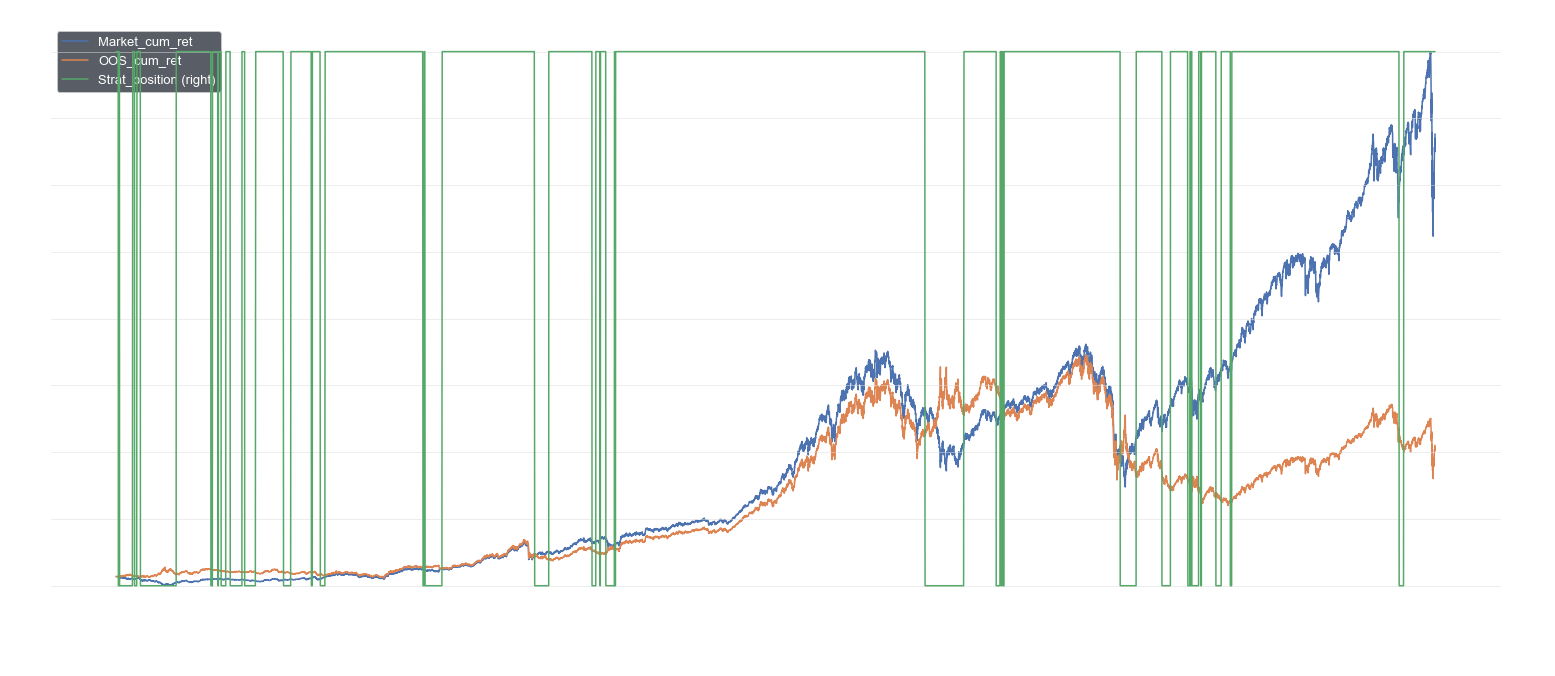

In [19]:
cols = ['Close', 'Strat_position', 'Market_daily_ret', 'OOS_daily_ret']
results_df = df.loc[OOS_start_years[0]:OOS_end_years[-1], cols].copy()

show_oos_plot(results_df)

results_df.tail(1)
results_df['Strat_position'].value_counts()

### Getting stats from OOS performance

In [20]:
html_df = results_df.copy()

In [21]:
#qs.reports.html(html_df['OOS_daily_ret'], html_df['Market_daily_ret'])

In [22]:
#qs.reports.html(html_df['OOS_cum_ret'], html_df['Market_cum_ret'])

In [23]:
#qs.reports.full(results_df['OOS_daily_ret'], results_df['Market_daily_ret'])